In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from numpy.fft import fftshift, fft2
from scipy.signal import convolve2d

In [148]:
def get_psf(D,epsilon,w_support,N,theta=0,Lambda=454):
    """
    D 是望远镜口径 mm
    epsilon是副镜遮挡比 %
    w support是支架的厚度 mm
    N是网格尺寸 int
    theta是支架旋转角度 deg
    Lmabda观测波长 nm
    """
    theta /= 180/np.pi
    Lambda /= 10**6
    # 模拟区域边长
    L = D*1.2
    # 空间分辨率
    dx = L/N
    
    # 坐标网格
    x = np.linspace(-L/2, L/2, N)
    y = np.linspace(-L/2, L/2, N)
    X, Y = np.meshgrid(x, y)
    X_rot = X * np.cos(theta) + Y * np.sin(theta)
    Y_rot = -X * np.sin(theta) + Y * np.cos(theta)
    R = np.sqrt(X**2 + Y**2)

    # 主镜 annular 函数
    A_annulus = np.logical_and(R >= epsilon * D / 2, R <= D / 2).astype(float)

    # 蜘蛛支架函数：两条支架（水平和竖直）
    A_spider1 = (np.abs(X_rot) < w_support / 2).astype(float)  # 竖直支架
    A_spider2 = (np.abs(Y_rot) < w_support / 2).astype(float)  # 水平支架

    # 总入瞳函数
    A_total = A_annulus * (1 - A_spider1) * (1 - A_spider2)
    
    # 计算点扩散函数（PSF）
    PSF = np.abs(fftshift(fft2(A_total)))**2
    PSF /= PSF.max()  # 归一化

    theta_x = x/L*Lambda*180/np.pi
    theta_y = y/L*Lambda*180/np.pi
    
    return x,y,A_total,theta_x,theta_y,PSF


def generate_stars(d_theta_x,d_theta_y,center_x,center_y,width_x,width_y):
    lenx = int( width_x/d_theta_x )
    leny = int( width_y/d_theta_y )
    sky = np.zeros( (leny,lenx) )+1e-20
    sky_x = np.arange( center_x - width_x/2, center_x + width_x/2, d_theta_x )
    sky_y = np.arange( center_y - width_y/2, center_y + width_y/2, d_theta_y )
    star_r = 1
    #sky[int(leny/4-star_r):int(leny/4+star_r),int(lenx/4-star_r):int(lenx/4+star_r)] = 1
    #sky[int(leny/4-star_r):int(leny/4+star_r),int(3*lenx/4-star_r):int(3*lenx/4+star_r)] = 1
    sky[int(leny/2-star_r):int(leny/2+star_r),int(lenx/2-star_r):int(lenx/2+star_r)] = 100
    #sky[int(3*leny/4-star_r):int(3*leny/4+star_r),int(3*lenx/4-star_r):int(3*lenx/4+star_r)] = 1
    #sky[int(3*leny/4-star_r):int(3*leny/4+star_r),int(lenx/4-star_r):int(lenx/4+star_r)] = 1
    return sky_x, sky_y, sky

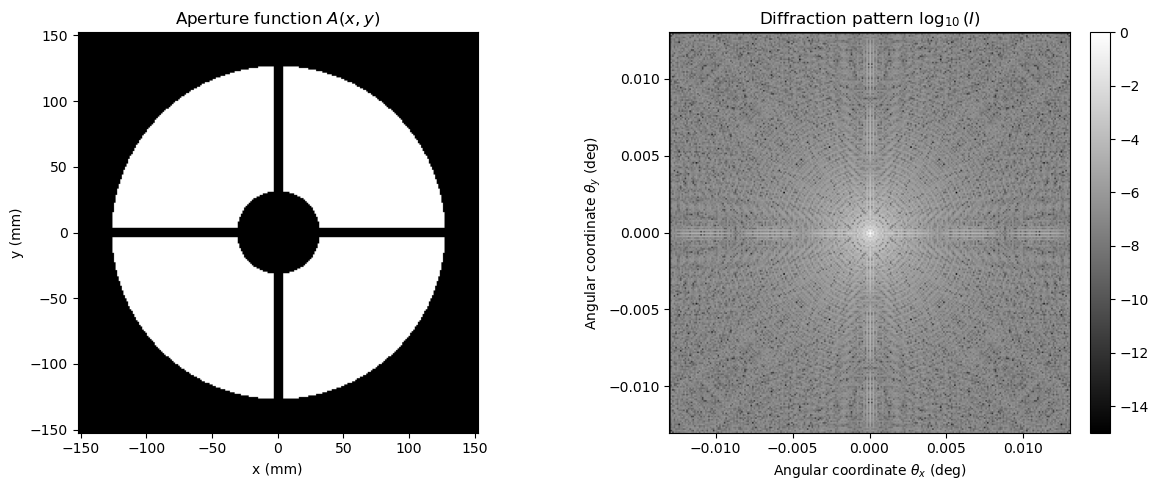

In [150]:
Ax,Ay,A_total,theta_x,theta_y,PSF = get_psf(254,0.25,7.5,256,theta=0)

# Plot aperture and PSF
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(A_total, cmap='gray', extent=[np.min(Ax), np.max(Ax), np.min(Ay), np.max(Ay)])
axs[0].set_title("Aperture function $A(x, y)$")
axs[0].set_xlabel("x (mm)")
axs[0].set_ylabel("y (mm)")

img1 = axs[1].imshow(np.log10(PSF + 1e-15), cmap='gray', extent=[np.min(theta_x), np.max(theta_x), np.min(theta_y), np.max(theta_y)])
#axs[1].imshow(PSF[1024-12:1024+12,1024-12:1024+12], cmap='gray', extent=[-1, 1, -1, 1])
axs[1].set_title("Diffraction pattern $\\log_{10}(I)$")
axs[1].set_xlabel("Angular coordinate $\\theta_x$ (deg)")
axs[1].set_ylabel("Angular coordinate $\\theta_y$ (deg)")
fig.colorbar(img1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

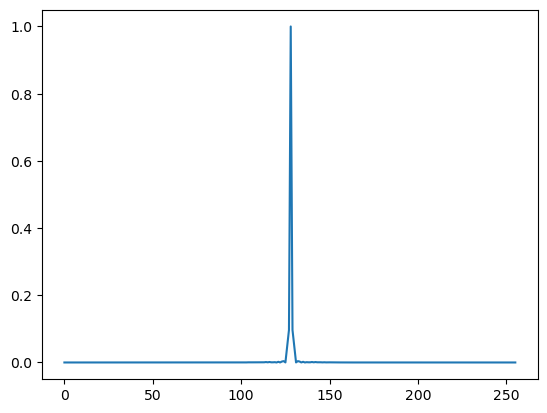

In [151]:
plt.plot( PSF[128] )

In [153]:
dtx = theta_x[2] - theta_x[1]
dty = theta_y[2] - theta_y[1]
skyx,skyy,skymap = generate_stars(dtx,dty,0,0,0.1,0.05)

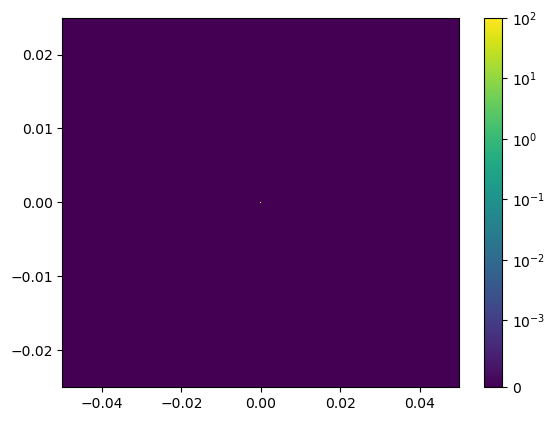

In [156]:
plt.pcolormesh(skyx,skyy,skymap,norm=mcolors.SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=0, vmax=100))
plt.colorbar()

In [157]:
result = convolve2d(skymap, PSF, mode='same', boundary='fill', fillvalue=0)

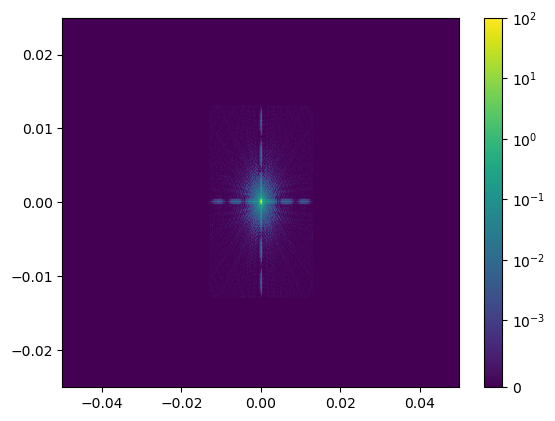

In [159]:
plt.pcolormesh( skyx,skyy,result,norm=mcolors.SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=0, vmax=100) )
plt.colorbar()